In [1]:
import random 
random.seed(42)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class AsianOptionMonteCarlo:
    def __init__(self, S0, K, r, sigma, T, N, M, strike_type='fixed', avg_type='arithmetic'):
        """
        Asian Option Monte Carlo Pricing
        
        Parameters:
        S0 : float  - Initial stock price
        K  : float  - Strike price (only used for fixed strike)
        r  : float  - Risk-free interest rate
        sigma : float - Volatility of the underlying asset
        T  : float  - Time to expiration (in years)
        N  : int    - Number of time steps
        M  : int    - Number of Monte Carlo simulations
        strike_type : str - 'fixed' or 'floating'
        avg_type    : str - 'arithmetic' or 'geometric'
        """
        self.__S0 = S0
        self.__K = K
        self.__r = r
        self.__sigma = sigma
        self.__T = T
        self.__N = N
        self.__M = M
        self.__dt = T / N
        self.__strike_type = strike_type
        self.__avg_type = avg_type

    def generate_paths(self):
        """Simulate stock price paths using Geometric Brownian Motion"""
        S = np.zeros((self.__M, self.__N + 1))
        S[:, 0] = self.__S0
        
        for t in range(1, self.__N + 1):
            Z = np.random.standard_normal(self.__M)
            S[:, t] = S[:, t - 1] + self.__r * S[:, t - 1] * self.__dt + self.__sigma * S[:, t - 1] * np.sqrt(self.__dt) * Z
        
        return S
    
    def price_option(self, option_type='call'):
        """Price an Asian option using Monte Carlo simulation"""
        S = self.generate_paths()
        # Compute the average stock price
        if self.__avg_type == 'arithmetic':
            avg_price = np.mean(S[:, 1:], axis=1)
        elif self.__avg_type == 'geometric':
            avg_price = np.exp(np.mean(np.log(S[:, 1:]), axis=1))
        else:
            raise ValueError("Invalid averaging type")
        
        # Compute payoffs
        if self.__strike_type == 'fixed':
            K = self.__K
            if option_type == 'call':
                payoffs = np.maximum(avg_price - K, 0)
            elif option_type == 'put':
                payoffs = np.maximum(K - avg_price, 0)
        elif self.__strike_type == 'floating':
            # Extract the final stock price at T
            S_T = S[:, -1]  
            if option_type == 'call':
                payoffs = np.maximum(S_T - avg_price, 0)
            elif option_type == 'put':
                payoffs = np.maximum(avg_price - S_T, 0)
        else:
            raise ValueError("Invalid strike type")
        
        # Discount the payoffs to present value
        option_price = np.exp(-self.__r * self.__T) * np.mean(payoffs)
        std_error = np.exp(-self.__r * self.__T) * np.std(payoffs) / np.sqrt(self.__M)
        return option_price, std_error
    
    
#S[:, t] = S[:, t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * Z) #multiplicative brownian motion

In [3]:

S0 = 100
r = 0.01
N_sim = 10000
M = 100

# The 4 Asian Option Types
averaging_types = ['arithmetic', 'geometric']
strike_types = ['fixed', 'floating']
option_types = ['call', 'put']

# Table 2 values
options_data = [
    {'label': '#1', 'K': 120.00, 'mu': 0.08, 'sigma': 0.20, 'T_days': 30},
    {'label': '#2', 'K': 80.00,  'mu': 0.05, 'sigma': 0.20, 'T_days': 30},
    {'label': '#3', 'K': 100.00, 'mu': 0.08, 'sigma': 0.25, 'T_days': 90},
    {'label': '#4', 'K': 80.00,  'mu': 0.04, 'sigma': 0.15, 'T_days': 60},
    {'label': '#5', 'K': 150.00, 'mu': 0.08, 'sigma': 0.40, 'T_days': 90},
]

In [4]:

# --- Run and display results ---
for data in options_data:
    print(f"\n==== {data['label']} ====")
    T = data['T_days'] / 365  # convert days to years
    for avg in averaging_types:
        for strike in strike_types:
            for otype in option_types:
                pricer = AsianOptionMonteCarlo(
                    S0=S0, K=data['K'], r=r, sigma=data['sigma'],
                    T=T, N=M, M=N_sim,
                    avg_type=avg,
                    strike_type=strike
                )
                price, se = pricer.price_option(option_type=otype)
                print(f"{otype.capitalize()} | {avg} avg | {strike} strike => Price: {price:.4f}, StdErr: {se:.4f}")


==== #1 ====
Call | arithmetic avg | fixed strike => Price: 0.0000, StdErr: 0.0000
Put | arithmetic avg | fixed strike => Price: 19.9348, StdErr: 0.0337
Call | arithmetic avg | floating strike => Price: 1.3418, StdErr: 0.0202
Put | arithmetic avg | floating strike => Price: 1.2815, StdErr: 0.0183
Call | geometric avg | fixed strike => Price: 0.0000, StdErr: 0.0000
Put | geometric avg | fixed strike => Price: 19.9483, StdErr: 0.0330
Call | geometric avg | floating strike => Price: 1.3353, StdErr: 0.0201
Put | geometric avg | floating strike => Price: 1.2778, StdErr: 0.0185

==== #2 ====
Call | arithmetic avg | fixed strike => Price: 20.0388, StdErr: 0.0336
Put | arithmetic avg | fixed strike => Price: 0.0000, StdErr: 0.0000
Call | arithmetic avg | floating strike => Price: 1.2867, StdErr: 0.0195
Put | arithmetic avg | floating strike => Price: 1.3088, StdErr: 0.0185
Call | geometric avg | fixed strike => Price: 20.0623, StdErr: 0.0334
Put | geometric avg | fixed strike => Price: 0.0000

QUESTION 1

In [5]:
# 1. Varying number of simulations (M) and plotting option prices and standard error
simulations = range(100,10000,100) 
call_prices = []
put_prices = []
call_errors = []
put_errors = []

for M in simulations:
    option = AsianOptionMonteCarlo(S0=100, K=120, r=0.08, sigma=0.2, T=30/365, N=100, M=M)
    call_price, call_error = option.price_option('call')
    put_price, put_error = option.price_option('put')
    call_prices.append(call_price)
    put_prices.append(put_price)
    call_errors.append(call_error)
    put_errors.append(put_error)


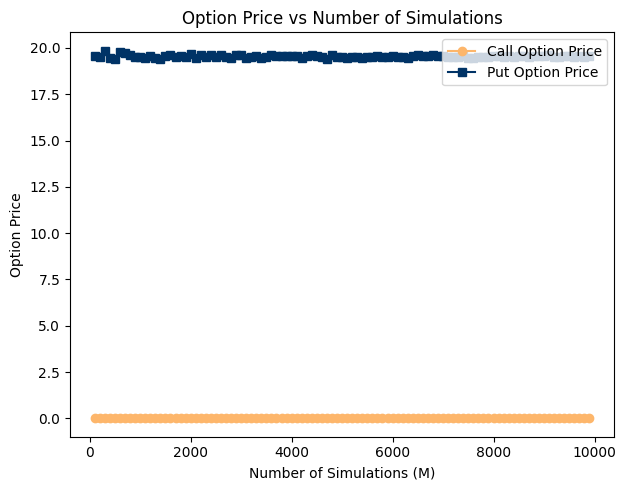

In [6]:

# Plot call and put prices vs number of simulations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(simulations, call_prices, marker='o', color='#FDB66B', label='Call Option Price')   # light orange
plt.plot(simulations, put_prices, marker='s', color='#003366', label='Put Option Price')    # dark blue

plt.xlabel("Number of Simulations (M)")
plt.ylabel("Option Price")
plt.title("Option Price vs Number of Simulations")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


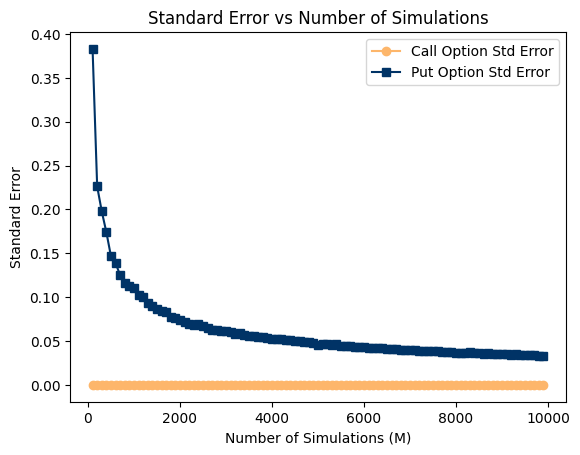

In [7]:
# Plot standard error vs number of simulations
plt.plot(simulations, call_errors, marker='o', color='#FDB66B', label='Call Option Std Error')
plt.plot(simulations, put_errors, marker='s', color='#003366', label='Put Option Std Error')
plt.xlabel("Number of Simulations (M)")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Number of Simulations")
plt.legend(loc='upper right')
plt.show()

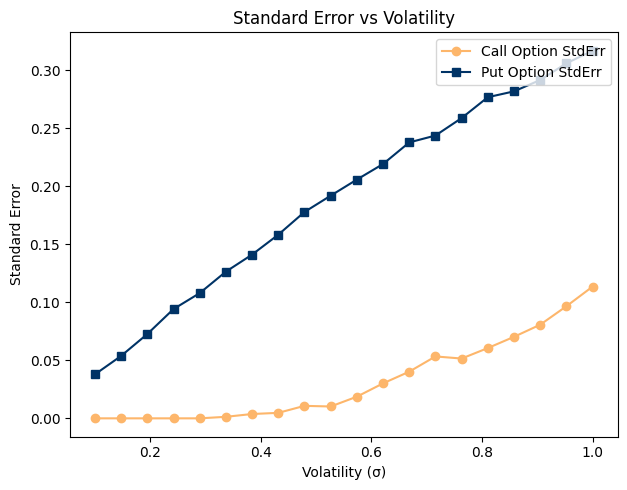

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
vol_range = np.linspace(0.1, 1.0, 20)
call_errors = []
put_errors = []

# --- Compute standard errors for various volatilities ---
for sigma in vol_range:
    option = AsianOptionMonteCarlo(S0=100, K=120, r=0.01, sigma=sigma, T=30/365, N=100, M=2000)
    call_price, call_error = option.price_option('call')
    put_price, put_error = option.price_option('put')
    call_errors.append(call_error)
    put_errors.append(put_error)

# --- Plot standard error vs volatility ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vol_range, call_errors, color='#FDB66B', marker='o', label='Call Option StdErr')
plt.plot(vol_range, put_errors, color='#003366', marker='s', label='Put Option StdErr')
plt.xlabel("Volatility (σ)")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Volatility")
plt.legend(loc='upper right')

# Optional: Include the original simulation-size plot here as subplot (1, 2, 2)
# if combining both into a single figure

plt.tight_layout()
plt.show()


QUESTION 2

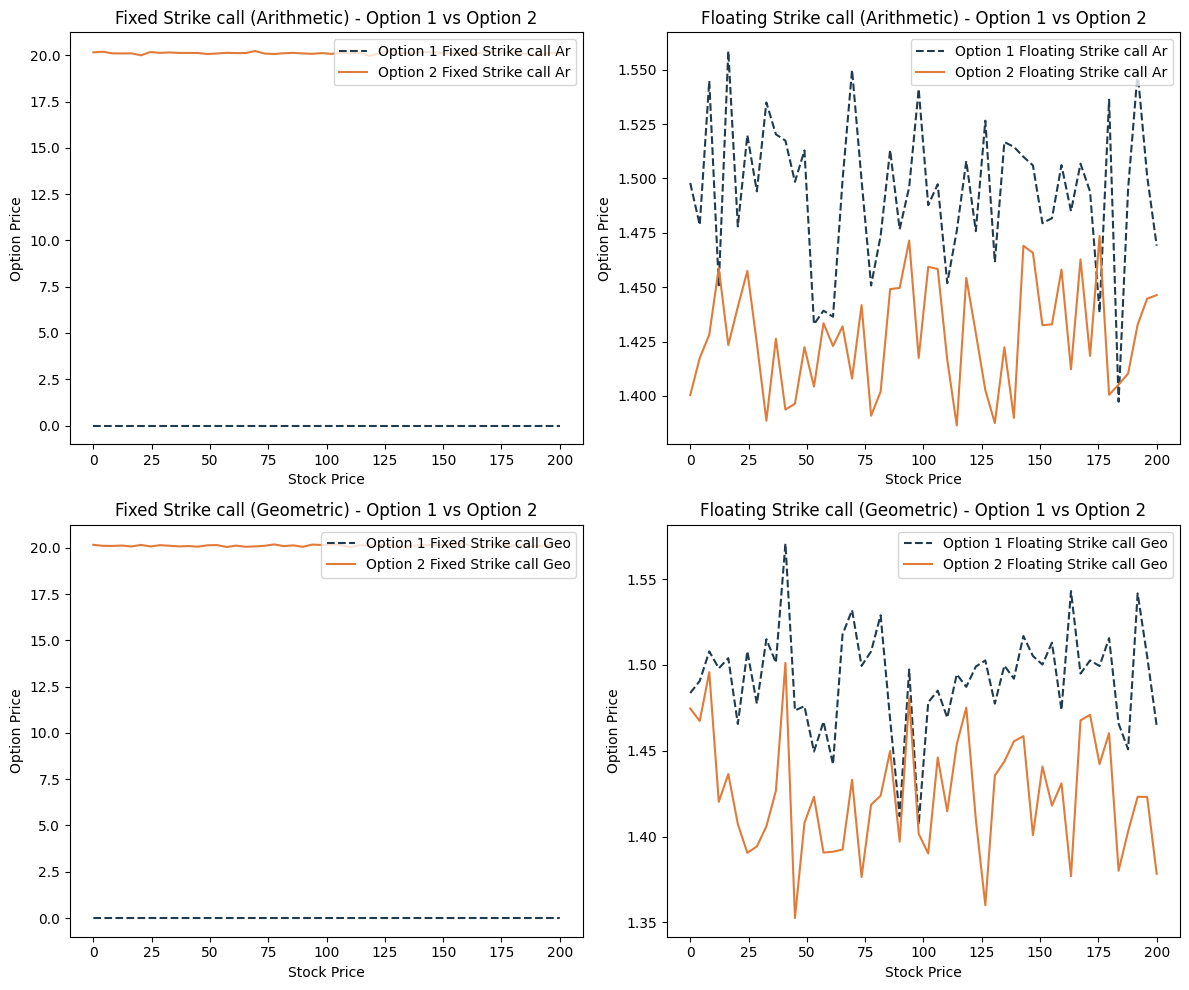

In [9]:

# 2. Option price vs Stock price for different Asian option types
stock_prices = np.linspace(0, 200, 50)
option1_call_prices_fixed_ar = []
option1_call_prices_fixed_geo = []
option1_call_prices_floating_ar = []
option1_call_prices_floating_geo = []
option2_call_prices_fixed_ar = []
option2_call_prices_fixed_geo = []
option2_call_prices_floating_ar = []
option2_call_prices_floating_geo = []

for S in stock_prices:
    option1_fixed_ar = AsianOptionMonteCarlo(S0=100, K=120, r=0.08, sigma=0.20, T=30/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option1_floating_ar = AsianOptionMonteCarlo(S0=100, K=120, r=0.08, sigma=0.20, T=30/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option1_fixed_geo = AsianOptionMonteCarlo(S0=100, K=120, r=0.08, sigma=0.20, T=30/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option1_floating_geo = AsianOptionMonteCarlo(S0=100, K=120, r=0.08, sigma=0.20, T=30/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option1_call_price_fixed_ar, _ = option1_fixed_ar.price_option('call')
    option1_call_price_fixed_geo, _ = option1_fixed_geo.price_option('call')
    option1_call_price_floating_ar, _ = option1_floating_ar.price_option('call')
    option1_call_price_floating_geo, _ = option1_floating_geo.price_option('call')

    option1_call_prices_fixed_ar.append(option1_call_price_fixed_ar)
    option1_call_prices_fixed_geo.append(option1_call_price_fixed_geo)
    option1_call_prices_floating_ar.append(option1_call_price_floating_ar)
    option1_call_prices_floating_geo.append(option1_call_price_floating_geo)
    
    option2_fixed_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.05, sigma=0.20, T=30/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option2_floating_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.05, sigma=0.20, T=30/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option2_fixed_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.05, sigma=0.20, T=30/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option2_floating_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.05, sigma=0.20, T=30/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option2_call_price_fixed_ar, _ = option2_fixed_ar.price_option('call')
    option2_call_price_fixed_geo, _ = option2_fixed_geo.price_option('call')
    option2_call_price_floating_ar, _ = option2_floating_ar.price_option('call')
    option2_call_price_floating_geo, _ = option2_floating_geo.price_option('call')
    
    option2_call_prices_fixed_ar.append(option2_call_price_fixed_ar)
    option2_call_prices_fixed_geo.append(option2_call_price_fixed_geo)
    option2_call_prices_floating_ar.append(option2_call_price_floating_ar)
    option2_call_prices_floating_geo.append(option2_call_price_floating_geo)
    
# Create subplots for visualizing results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define professional colors
color_option1 = '#1f3b4d'  # Navy Blue
color_option2 = '#e07b39'  # Burnt Orange

# Fixed Strike call (Arithmetic)
axs[0, 0].plot(stock_prices, option1_call_prices_fixed_ar, label="Option 1 Fixed Strike call Ar", linestyle='dashed', color=color_option1)
axs[0, 0].plot(stock_prices, option2_call_prices_fixed_ar, label="Option 2 Fixed Strike call Ar", color=color_option2)
axs[0, 0].set_title("Fixed Strike call (Arithmetic) - Option 1 vs Option 2")
axs[0, 0].set_xlabel("Stock Price")
axs[0, 0].set_ylabel("Option Price")
axs[0, 0].legend(loc='upper right')

# Floating Strike call (Arithmetic)
axs[0, 1].plot(stock_prices, option1_call_prices_floating_ar, label="Option 1 Floating Strike call Ar", linestyle='dashed', color=color_option1)
axs[0, 1].plot(stock_prices, option2_call_prices_floating_ar, label="Option 2 Floating Strike call Ar", color=color_option2)
axs[0, 1].set_title("Floating Strike call (Arithmetic) - Option 1 vs Option 2")
axs[0, 1].set_xlabel("Stock Price")
axs[0, 1].set_ylabel("Option Price")
axs[0, 1].legend(loc='upper right')

# Fixed Strike call (Geometric)
axs[1, 0].plot(stock_prices, option1_call_prices_fixed_geo, label="Option 1 Fixed Strike call Geo", linestyle='dashed', color=color_option1)
axs[1, 0].plot(stock_prices, option2_call_prices_fixed_geo, label="Option 2 Fixed Strike call Geo", color=color_option2)
axs[1, 0].set_title("Fixed Strike call (Geometric) - Option 1 vs Option 2")
axs[1, 0].set_xlabel("Stock Price")
axs[1, 0].set_ylabel("Option Price")
axs[1, 0].legend(loc='upper right')

# Floating Strike call (Geometric)
axs[1, 1].plot(stock_prices, option1_call_prices_floating_geo, label="Option 1 Floating Strike call Geo", linestyle='dashed', color=color_option1)
axs[1, 1].plot(stock_prices, option2_call_prices_floating_geo, label="Option 2 Floating Strike call Geo", color=color_option2)
axs[1, 1].set_title("Floating Strike call (Geometric) - Option 1 vs Option 2")
axs[1, 1].set_xlabel("Stock Price")
axs[1, 1].set_ylabel("Option Price")
axs[1, 1].legend(loc='upper right')


plt.tight_layout()
plt.show()


QUESTION 3

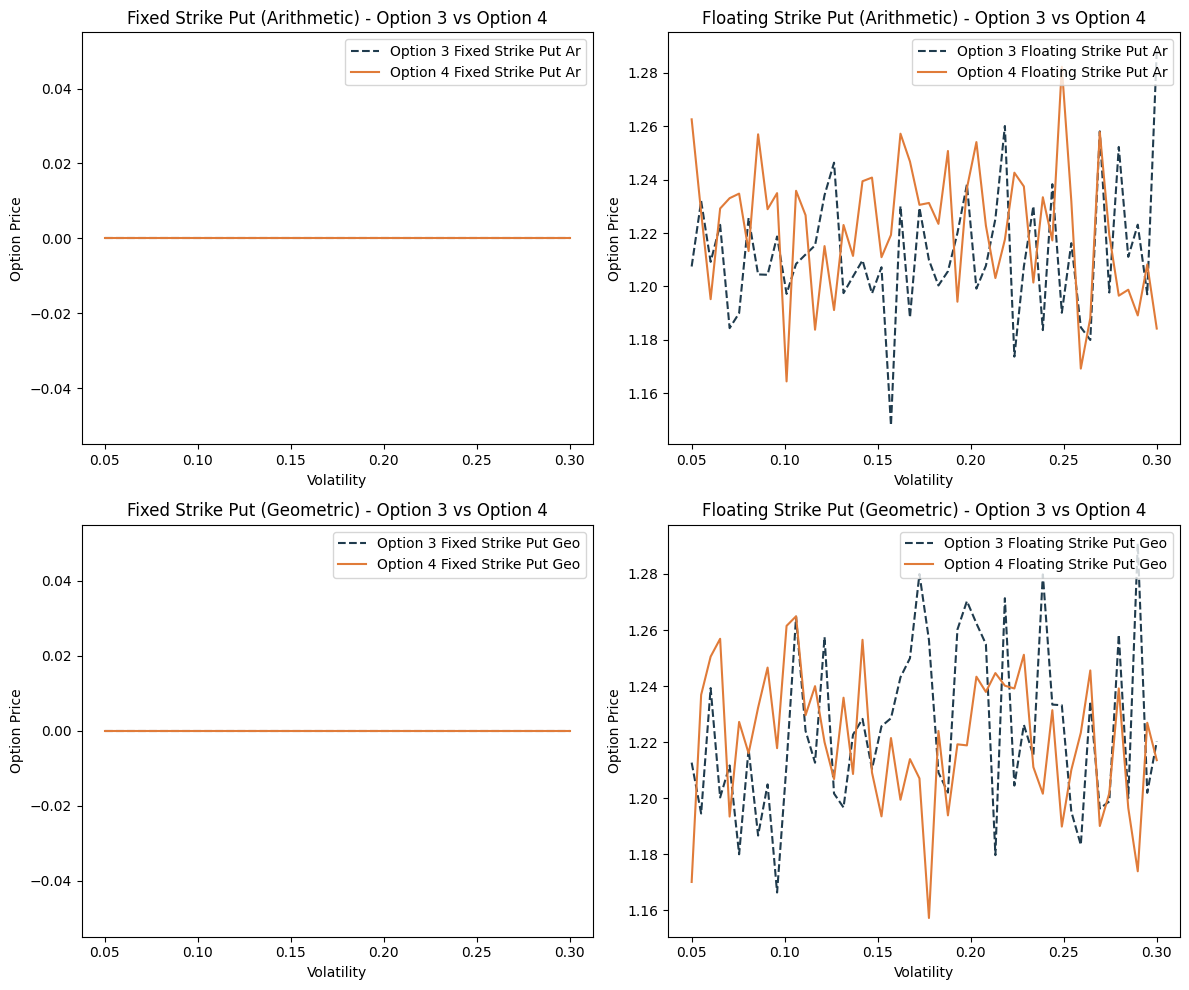

In [10]:

# 3. Put option price vs volatility
volatilities = np.linspace(0.05, 0.3, 50)
option3_put_prices_fixed_ar = []
option3_put_prices_fixed_geo = []
option3_put_prices_floating_ar = []
option3_put_prices_floating_geo = []
option4_put_prices_fixed_ar = []
option4_put_prices_fixed_geo = []
option4_put_prices_floating_ar = []
option4_put_prices_floating_geo = []

for sigma in volatilities:
    option3_fixed_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option3_floating_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option3_fixed_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option3_floating_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option3_put_price_fixed_ar, _ = option3_fixed_ar.price_option('put')
    option3_put_price_fixed_geo, _ = option3_fixed_geo.price_option('put')
    option3_put_price_floating_ar, _ = option3_floating_ar.price_option('put')
    option3_put_price_floating_geo, _ = option3_floating_geo.price_option('put')

    option3_put_prices_fixed_ar.append(option3_put_price_fixed_ar)
    option3_put_prices_fixed_geo.append(option3_put_price_fixed_geo)
    option3_put_prices_floating_ar.append(option3_put_price_floating_ar)
    option3_put_prices_floating_geo.append(option3_put_price_floating_geo)
    
    option4_fixed_ar = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option4_floating_ar = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option4_fixed_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option4_floating_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option4_put_price_fixed_ar, _ = option3_fixed_ar.price_option('put')
    option4_put_price_fixed_geo, _ = option3_fixed_geo.price_option('put')
    option4_put_price_floating_ar, _ = option3_floating_ar.price_option('put')
    option4_put_price_floating_geo, _ = option3_floating_geo.price_option('put')
    
    option4_put_prices_fixed_ar.append(option4_put_price_fixed_ar)
    option4_put_prices_fixed_geo.append(option4_put_price_fixed_geo)
    option4_put_prices_floating_ar.append(option4_put_price_floating_ar)
    option4_put_prices_floating_geo.append(option4_put_price_floating_geo)
    

# Create subplots for visualizing results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define professional colors
color_option3 = '#1f3b4d'  # Navy Blue
color_option4 = '#e07b39'  # Burnt Orange

# Fixed Strike Put (Arithmetic)
axs[0, 0].plot(volatilities, option3_put_prices_fixed_ar, label="Option 3 Fixed Strike Put Ar", linestyle='dashed', color=color_option3)
axs[0, 0].plot(volatilities, option4_put_prices_fixed_ar, label="Option 4 Fixed Strike Put Ar", color=color_option4)
axs[0, 0].set_title("Fixed Strike Put (Arithmetic) - Option 3 vs Option 4")
axs[0, 0].set_xlabel("Volatility")
axs[0, 0].set_ylabel("Option Price")
axs[0, 0].legend(loc='upper right')

# Floating Strike Put (Arithmetic)
axs[0, 1].plot(volatilities, option3_put_prices_floating_ar, label="Option 3 Floating Strike Put Ar", linestyle='dashed', color=color_option3)
axs[0, 1].plot(volatilities, option4_put_prices_floating_ar, label="Option 4 Floating Strike Put Ar", color=color_option4)
axs[0, 1].set_title("Floating Strike Put (Arithmetic) - Option 3 vs Option 4")
axs[0, 1].set_xlabel("Volatility")
axs[0, 1].set_ylabel("Option Price")
axs[0, 1].legend(loc='upper right')

# Fixed Strike Put (Geometric)
axs[1, 0].plot(volatilities, option3_put_prices_fixed_geo, label="Option 3 Fixed Strike Put Geo", linestyle='dashed', color=color_option3)
axs[1, 0].plot(volatilities, option4_put_prices_fixed_geo, label="Option 4 Fixed Strike Put Geo", color=color_option4)
axs[1, 0].set_title("Fixed Strike Put (Geometric) - Option 3 vs Option 4")
axs[1, 0].set_xlabel("Volatility")
axs[1, 0].set_ylabel("Option Price")
axs[1, 0].legend(loc='upper right')

# Floating Strike Put (Geometric)
axs[1, 1].plot(volatilities, option3_put_prices_floating_geo, label="Option 3 Floating Strike Put Geo", linestyle='dashed', color=color_option3)
axs[1, 1].plot(volatilities, option4_put_prices_floating_geo, label="Option 4 Floating Strike Put Geo", color=color_option4)
axs[1, 1].set_title("Floating Strike Put (Geometric) - Option 3 vs Option 4")
axs[1, 1].set_xlabel("Volatility")
axs[1, 1].set_ylabel("Option Price")
axs[1, 1].legend(loc='upper right')


plt.tight_layout()
plt.show()



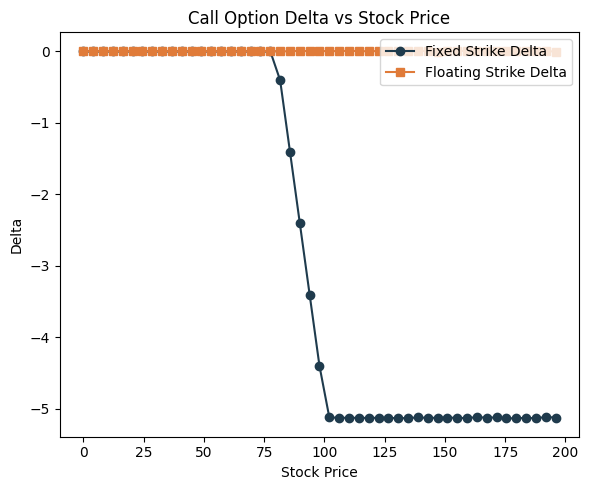

In [11]:
# 4. Delta (Call Option Sensitivity to Stock Price)
# Define professional colors
color_fixed = '#1f3b4d'     # Navy Blue
color_floating = '#e07b39'  # Burnt Orange

# --- Compute Deltas ---
deltas_fixed = []
deltas_floating = []

for i in range(len(stock_prices) - 1):
    S1, S2 = stock_prices[i], stock_prices[i + 1]

    # Fixed Strike
    option1_fixed = AsianOptionMonteCarlo(S0=S1, K=80, r=0.05, sigma=0.2, T=1/365, N=100, M=5000, strike_type='fixed')
    option2_fixed = AsianOptionMonteCarlo(S0=S2, K=105, r=0.05, sigma=0.2, T=1/365, N=100, M=5000, strike_type='fixed')

    # Floating Strike
    option1_floating = AsianOptionMonteCarlo(S0=S1, K=105, r=0.05, sigma=0.2, T=1/365, N=100, M=5000, strike_type='floating')
    option2_floating = AsianOptionMonteCarlo(S0=S2, K=105, r=0.05, sigma=0.2, T=1/365, N=100, M=5000, strike_type='floating')

    call_price1_fixed, _ = option1_fixed.price_option('call')
    call_price2_fixed, _ = option2_fixed.price_option('call')
    delta_fixed = (call_price2_fixed - call_price1_fixed) / (S2 - S1)
    deltas_fixed.append(delta_fixed)

    call_price1_floating, _ = option1_floating.price_option('call')
    call_price2_floating, _ = option2_floating.price_option('call')
    delta_floating = (call_price2_floating - call_price1_floating) / (S2 - S1)
    deltas_floating.append(delta_floating)

# --- Plot Delta Sensitivity ---
plt.figure(figsize=(6, 5))
plt.plot(stock_prices[:-1], deltas_fixed, label="Fixed Strike Delta", color=color_fixed, marker='o')
plt.plot(stock_prices[:-1], deltas_floating, label="Floating Strike Delta", color=color_floating, marker='s')

plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.title("Call Option Delta vs Stock Price")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


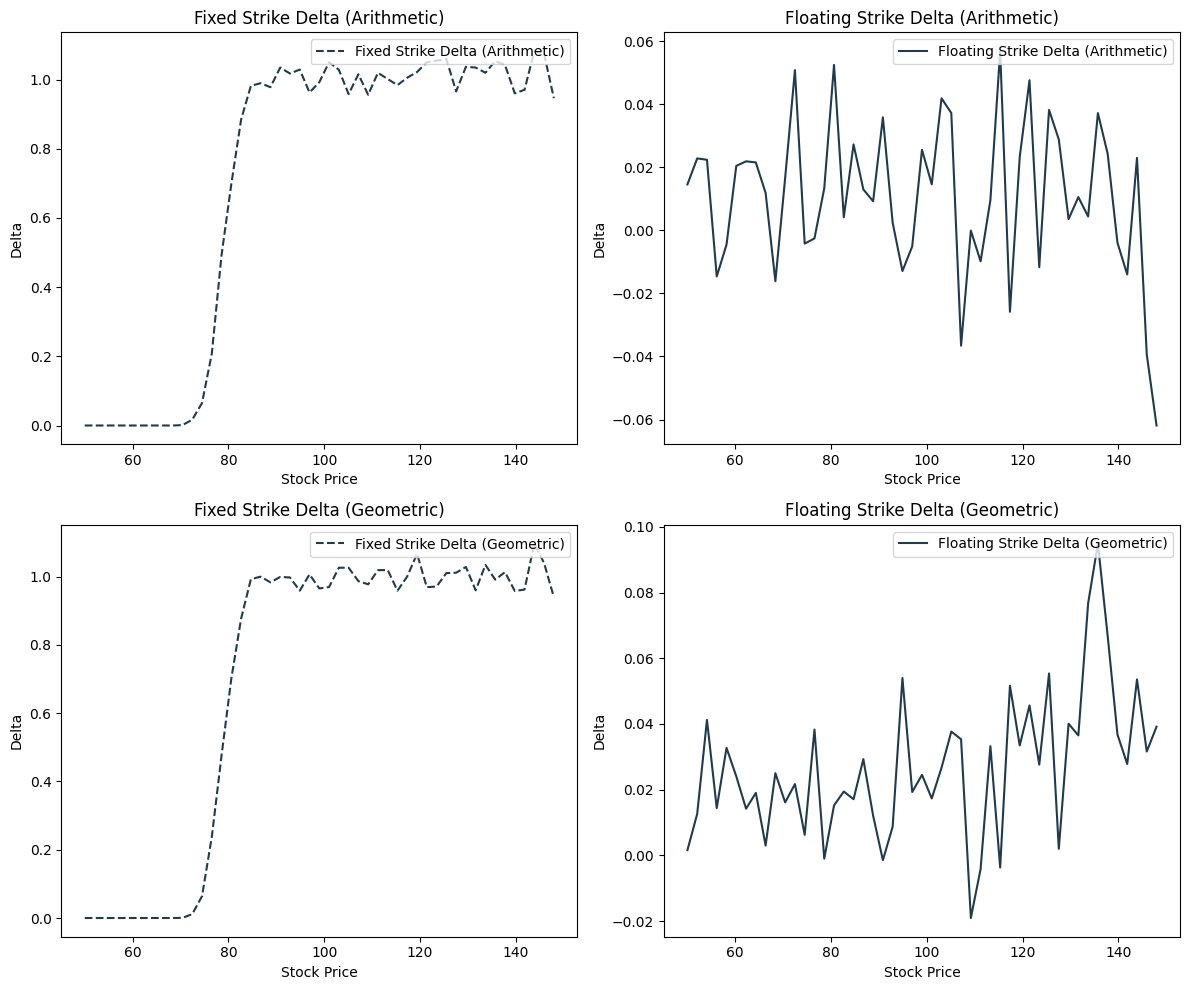

In [12]:
# Define the range of stock prices
stock_prices = np.linspace(50, 150, 50)

# Initialize lists to store delta values
deltas_fixed_ar = []
deltas_fixed_geo = []
deltas_floating_ar = []
deltas_floating_geo = []

# Compute delta for Option 4
for i in range(len(stock_prices) - 1):
    S1, S2 = stock_prices[i], stock_prices[i + 1]
    
    # Compute call option prices at two close stock prices for different averaging methods
    option1_fixed_ar = AsianOptionMonteCarlo(S0=S1, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option2_fixed_ar = AsianOptionMonteCarlo(S0=S2, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    
    option1_floating_ar = AsianOptionMonteCarlo(S0=S1, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="arithmetic")
    option2_floating_ar = AsianOptionMonteCarlo(S0=S2, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="arithmetic")

    option1_fixed_geo = AsianOptionMonteCarlo(S0=S1, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="geometric")
    option2_fixed_geo = AsianOptionMonteCarlo(S0=S2, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='fixed', avg_type="geometric")

    option1_floating_geo = AsianOptionMonteCarlo(S0=S1, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option2_floating_geo = AsianOptionMonteCarlo(S0=S2, K=80, r=0.04, sigma=0.15, T=60/365, N=100, M=5000, strike_type='floating', avg_type="geometric")

    # Compute call option prices
    call_price1_fixed_ar, _ = option1_fixed_ar.price_option('call')
    call_price2_fixed_ar, _ = option2_fixed_ar.price_option('call')

    call_price1_floating_ar, _ = option1_floating_ar.price_option('call')
    call_price2_floating_ar, _ = option2_floating_ar.price_option('call')

    call_price1_fixed_geo, _ = option1_fixed_geo.price_option('call')
    call_price2_fixed_geo, _ = option2_fixed_geo.price_option('call')

    call_price1_floating_geo, _ = option1_floating_geo.price_option('call')
    call_price2_floating_geo, _ = option2_floating_geo.price_option('call')

    # Compute delta
    delta_fixed_ar = (call_price2_fixed_ar - call_price1_fixed_ar) / (S2 - S1)
    delta_floating_ar = (call_price2_floating_ar - call_price1_floating_ar) / (S2 - S1)

    delta_fixed_geo = (call_price2_fixed_geo - call_price1_fixed_geo) / (S2 - S1)
    delta_floating_geo = (call_price2_floating_geo - call_price1_floating_geo) / (S2 - S1)

    deltas_fixed_ar.append(delta_fixed_ar)
    deltas_floating_ar.append(delta_floating_ar)
    deltas_fixed_geo.append(delta_fixed_geo)
    deltas_floating_geo.append(delta_floating_geo)

# Define professional navy blue
delta_color = '#1f3b4d'  # Navy Blue

# Create subplots for visualizing results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Fixed Strike Delta (Arithmetic)
axs[0, 0].plot(stock_prices[:-1], deltas_fixed_ar, label="Fixed Strike Delta (Arithmetic)", linestyle='dashed', color=delta_color)
axs[0, 0].set_title("Fixed Strike Delta (Arithmetic)")
axs[0, 0].set_xlabel("Stock Price")
axs[0, 0].set_ylabel("Delta")
axs[0, 0].legend(loc='upper right')

# Floating Strike Delta (Arithmetic)
axs[0, 1].plot(stock_prices[:-1], deltas_floating_ar, label="Floating Strike Delta (Arithmetic)", color=delta_color)
axs[0, 1].set_title("Floating Strike Delta (Arithmetic)")
axs[0, 1].set_xlabel("Stock Price")
axs[0, 1].set_ylabel("Delta")
axs[0, 1].legend(loc='upper right')

# Fixed Strike Delta (Geometric)
axs[1, 0].plot(stock_prices[:-1], deltas_fixed_geo, label="Fixed Strike Delta (Geometric)", linestyle='dashed', color=delta_color)
axs[1, 0].set_title("Fixed Strike Delta (Geometric)")
axs[1, 0].set_xlabel("Stock Price")
axs[1, 0].set_ylabel("Delta")
axs[1, 0].legend(loc='upper right')

# Floating Strike Delta (Geometric)
axs[1, 1].plot(stock_prices[:-1], deltas_floating_geo, label="Floating Strike Delta (Geometric)", color=delta_color)
axs[1, 1].set_title("Floating Strike Delta (Geometric)")
axs[1, 1].set_xlabel("Stock Price")
axs[1, 1].set_ylabel("Delta")
axs[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.show()



# ARCHIVE

/var/folders/cx/g7tjhywj3cb275lvqj0049rr0000gn/T/ipykernel_64810/3594132499.py:49: RuntimeWarning: invalid value encountered in log
  avg_price = np.exp(np.mean(np.log(S[:, 1:]), axis=1))


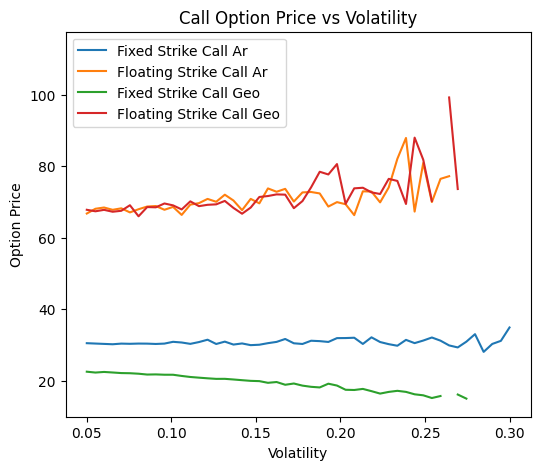

In [13]:
# OPTION 4
# 3. Call option price vs volatility
volatilities = np.linspace(0.05, 0.3, 50)
call_prices_fixed_ar = []
call_prices_fixed_geo = []
call_prices_floating_ar = []
call_prices_floating_geo = []

for sigma in volatilities:
    option_fixed_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=sigma, T=60, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option_floating_ar = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=sigma, T=60, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option_fixed_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=sigma, T=60, N=100, M=5000, strike_type='fixed', avg_type="geometric")
    option_floating_geo = AsianOptionMonteCarlo(S0=100, K=80, r=0.04, sigma=sigma, T=60, N=100, M=5000, strike_type='floating', avg_type="geometric")
    
    call_price_fixed_ar, _ = option_fixed_ar.price_option('call')
    call_price_fixed_geo, _ = option_fixed_geo.price_option('call')
    call_price_floating_ar, _ = option_floating_ar.price_option('call')
    call_price_floating_geo, _ = option_floating_geo.price_option('call')

    call_prices_fixed_ar.append(call_price_fixed_ar)
    call_prices_fixed_geo.append(call_price_fixed_geo)
    call_prices_floating_ar.append(call_price_floating_ar)
    call_prices_floating_geo.append(call_price_floating_geo)

plt.figure(figsize=(6, 5))
plt.plot(volatilities, call_prices_fixed_ar, label="Fixed Strike Call Ar")
plt.plot(volatilities, call_prices_floating_ar, label="Floating Strike Call Ar")
plt.plot(volatilities, call_prices_fixed_geo, label="Fixed Strike Call Geo")
plt.plot(volatilities, call_prices_floating_geo, label="Floating Strike Call Geo")
plt.xlabel("Volatility")
plt.ylabel("Option Price")
plt.title("Call Option Price vs Volatility")
plt.legend()
plt.show()


/var/folders/cx/g7tjhywj3cb275lvqj0049rr0000gn/T/ipykernel_64810/3594132499.py:49: RuntimeWarning: invalid value encountered in log
  avg_price = np.exp(np.mean(np.log(S[:, 1:]), axis=1))


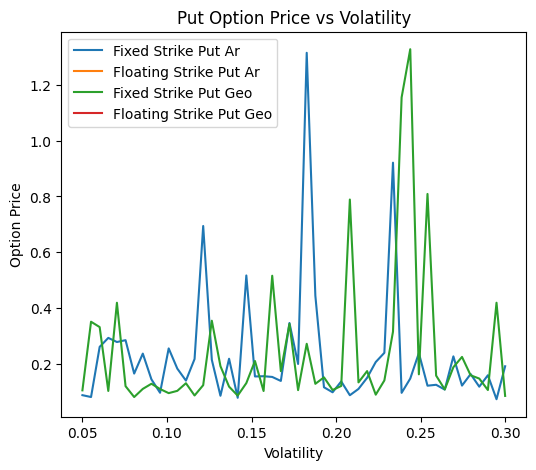

In [14]:
# OPTION 5
# 3. Put option price vs volatility
volatilities = np.linspace(0.05, 0.3, 50)
put_prices_fixed_ar = []
put_prices_fixed_geo = []
put_prices_floating_ar = []
put_prices_floating_geo = []

for sigma in volatilities:
    option_fixed_ar = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option_floating_ar = AsianOptionMonteCarlo(S0=100,  K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option_fixed_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option_floating_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='floating', avg_type="geometric")
    
    put_price_fixed_ar, _ = option_fixed_ar.price_option('put')
    put_price_fixed_geo, _ = option_fixed_geo.price_option('put')
    put_price_floating_ar, _ = option_floating_ar.price_option('put')
    put_price_floating_geo, _ = option_floating_geo.price_option('put')

    put_prices_fixed_ar.append(put_price_fixed_ar)
    put_prices_fixed_geo.append(put_price_fixed_geo)
    put_prices_floating_ar.append(put_price_floating_ar)
    put_prices_floating_geo.append(put_price_floating_geo)

    
plt.figure(figsize=(6, 5))
plt.plot(volatilities, put_prices_fixed_ar, label="Fixed Strike Put Ar")
plt.plot(volatilities, put_prices_floating_ar, label="Floating Strike Put Ar")
plt.plot(volatilities, put_prices_fixed_geo, label="Fixed Strike Put Geo")
plt.plot(volatilities, put_prices_floating_geo, label="Floating Strike Put Geo")
plt.xlabel("Volatility")
plt.ylabel("Option Price")
plt.title("Put Option Price vs Volatility")
plt.legend()
plt.show()




/var/folders/cx/g7tjhywj3cb275lvqj0049rr0000gn/T/ipykernel_64810/3594132499.py:49: RuntimeWarning: invalid value encountered in log
  avg_price = np.exp(np.mean(np.log(S[:, 1:]), axis=1))


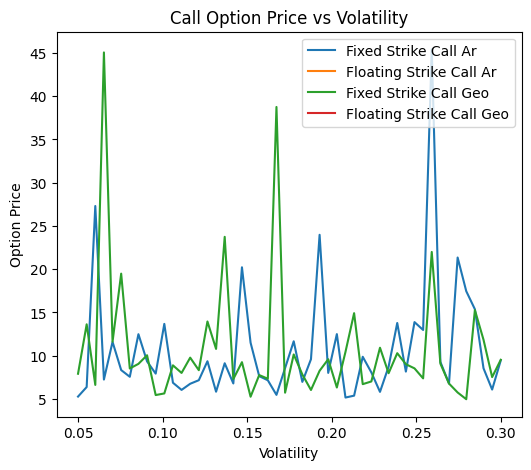

In [15]:
# OPTION 5
# 3. Call option price vs volatility
volatilities = np.linspace(0.05, 0.3, 50)
call_prices_fixed_ar = []
call_prices_fixed_geo = []
call_prices_floating_ar = []
call_prices_floating_geo = []

for sigma in volatilities:
    option_fixed_ar = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option_floating_ar = AsianOptionMonteCarlo(S0=100,  K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='floating', avg_type="geometric")
    option_fixed_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='fixed', avg_type="arithmetic")
    option_floating_geo = AsianOptionMonteCarlo(S0=100, K=150, r=0.08, sigma=0.40, T=90, N=100, M=5000, strike_type='floating', avg_type="geometric")
    
    call_price_fixed_ar, _ = option_fixed_ar.price_option('call')
    call_price_fixed_geo, _ = option_fixed_geo.price_option('call')
    call_price_floating_ar, _ = option_floating_ar.price_option('call')
    call_price_floating_geo, _ = option_floating_geo.price_option('call')

    call_prices_fixed_ar.append(call_price_fixed_ar)
    call_prices_fixed_geo.append(call_price_fixed_geo)
    call_prices_floating_ar.append(call_price_floating_ar)
    call_prices_floating_geo.append(call_price_floating_geo)

    
plt.figure(figsize=(6, 5))
plt.plot(volatilities, call_prices_fixed_ar, label="Fixed Strike Call Ar")
plt.plot(volatilities, call_prices_floating_ar, label="Floating Strike Call Ar")
plt.plot(volatilities, call_prices_fixed_geo, label="Fixed Strike Call Geo")
plt.plot(volatilities, call_prices_floating_geo, label="Floating Strike Call Geo")
plt.xlabel("Volatility")
plt.ylabel("Option Price")
plt.title("Call Option Price vs Volatility")
plt.legend()
plt.show()



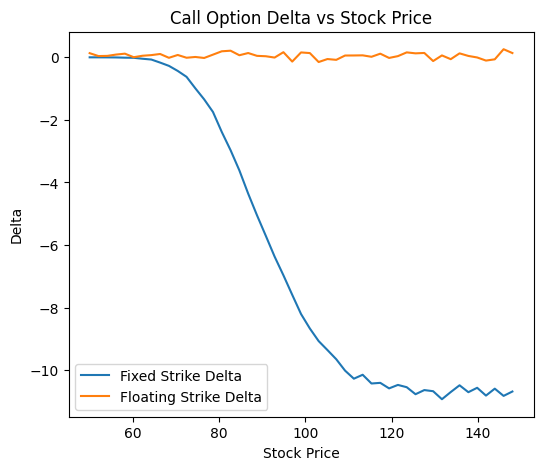

In [16]:
# 4. Delta (Call Option Sensitivity to Stock Price)
deltas_fixed = []
deltas_floating = []

for i in range(len(stock_prices) - 1):
    S1, S2 = stock_prices[i], stock_prices[i + 1]
    option1_fixed = AsianOptionMonteCarlo(S0=S1, K= 80, r=0.05, sigma=0.2, T=1, N=100, M=5000, strike_type='fixed')
    option2_fixed = AsianOptionMonteCarlo(S0=S2, K=105, r=0.05, sigma=0.2, T=1, N=100, M=5000, strike_type='fixed')

    option1_floating = AsianOptionMonteCarlo(S0=S1, K=105, r=0.05, sigma=0.2, T=1, N=100, M=5000, strike_type='floating')
    option2_floating = AsianOptionMonteCarlo(S0=S2, K=105, r=0.05, sigma=0.2, T=1, N=100, M=5000, strike_type='floating')

    call_price1_fixed, _ = option1_fixed.price_option('call')
    call_price2_fixed, _ = option2_fixed.price_option('call')

    call_price1_floating, _ = option1_floating.price_option('call')
    call_price2_floating, _ = option2_floating.price_option('call')

    delta_fixed = (call_price2_fixed - call_price1_fixed) / (S2 - S1)
    delta_floating = (call_price2_floating - call_price1_floating) / (S2 - S1)

    deltas_fixed.append(delta_fixed)
    deltas_floating.append(delta_floating)

plt.figure(figsize=(6, 5))
plt.plot(stock_prices[:-1], deltas_fixed, label="Fixed Strike Delta")
plt.plot(stock_prices[:-1], deltas_floating, label="Floating Strike Delta")
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.title("Call Option Delta vs Stock Price")
plt.legend()
plt.show()

In [17]:
import numpy as np
Z= np.random.standard_normal(3)
